In [3]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


BASE_PATH = '/kaggle/input/image-de-photobombing-benchmark-dpd-300-dataset'
IMAGE_DIR = os.path.join(BASE_PATH, 'dataset') 
MASK_DIR = os.path.join(BASE_PATH, 'mask')
IMAGE_SIZE = 512
BATCH_SIZE = 4


transform_image = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalizing to [-1, 1]
])

transform_mask = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Keep in [0, 1]
])


class DPDMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img, transform_mask):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale

        return self.transform_img(image), self.transform_mask(mask)


dataset = DPDMaskDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transform_img=transform_image,
    transform_mask=transform_mask
)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [4]:
import torch
import torchvision
from torch import nn
import torch.optim as optim

# Load pretrained DeepLabV3+ with ResNet-101 backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

# Replace classifier head for binary segmentation
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  


for param in model.backbone.parameters():
    param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Binary classification per pixel
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 199MB/s]  


In [5]:
import torch.nn.functional as F

EPOCHS = 10  # You can increase this after testing
print_interval = 10  # Show loss every 10 batches

model.train()  # Set model to training mode

for epoch in range(EPOCHS):
    running_loss = 0.0
    
    for i, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)['out']  # Get predicted masks (logits)
        outputs = outputs.squeeze(1)    # From [B,1,H,W] -> [B,H,W]
        masks = masks.squeeze(1)        # [B,1,H,W] -> [B,H,W]

        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print status
        if (i + 1) % print_interval == 0:
            avg_loss = running_loss / print_interval
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(dataloader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0

print("✅ Training completed.")


Epoch [1/10], Step [10/78], Loss: 0.7368
Epoch [1/10], Step [20/78], Loss: 0.6819
Epoch [1/10], Step [30/78], Loss: 0.6363
Epoch [1/10], Step [40/78], Loss: 0.5955
Epoch [1/10], Step [50/78], Loss: 0.5533
Epoch [1/10], Step [60/78], Loss: 0.5170
Epoch [1/10], Step [70/78], Loss: 0.5049
Epoch [2/10], Step [10/78], Loss: 0.4340
Epoch [2/10], Step [20/78], Loss: 0.4223
Epoch [2/10], Step [30/78], Loss: 0.4153
Epoch [2/10], Step [40/78], Loss: 0.3684
Epoch [2/10], Step [50/78], Loss: 0.3963
Epoch [2/10], Step [60/78], Loss: 0.3700
Epoch [2/10], Step [70/78], Loss: 0.3531
Epoch [3/10], Step [10/78], Loss: 0.3379
Epoch [3/10], Step [20/78], Loss: 0.3188
Epoch [3/10], Step [30/78], Loss: 0.3023
Epoch [3/10], Step [40/78], Loss: 0.3039
Epoch [3/10], Step [50/78], Loss: 0.2950
Epoch [3/10], Step [60/78], Loss: 0.3068
Epoch [3/10], Step [70/78], Loss: 0.2894
Epoch [4/10], Step [10/78], Loss: 0.2445
Epoch [4/10], Step [20/78], Loss: 0.2529
Epoch [4/10], Step [30/78], Loss: 0.2367
Epoch [4/10], St

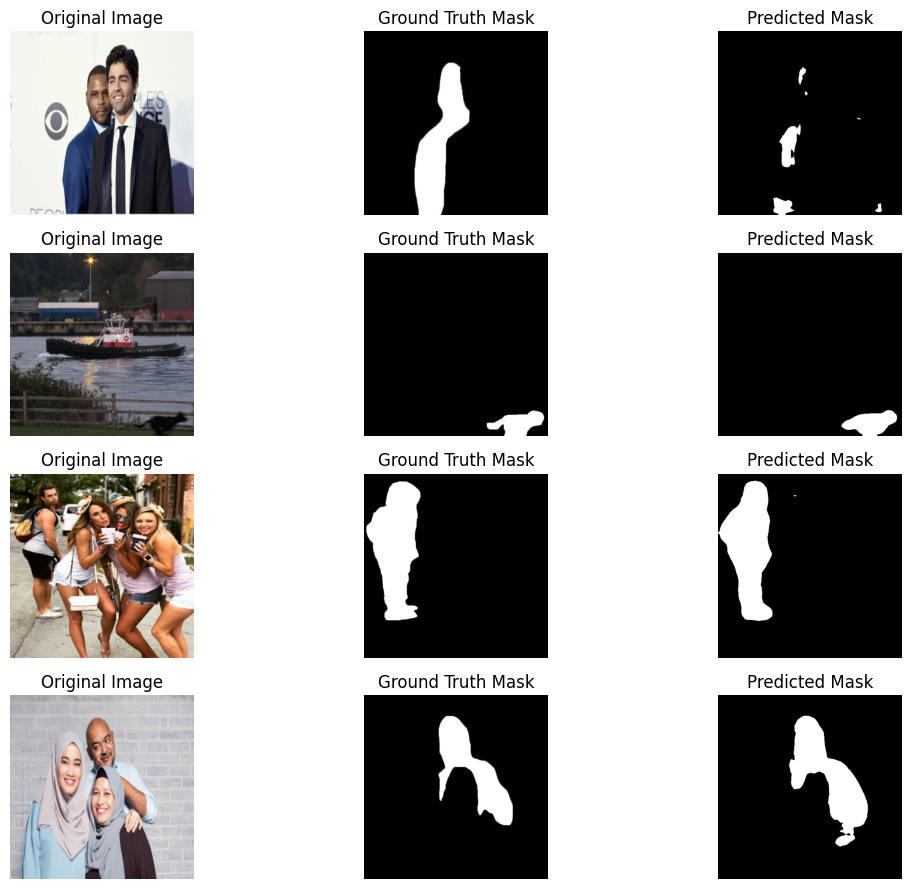

In [6]:
import matplotlib.pyplot as plt
import numpy as np


model.eval()

with torch.no_grad():
    # Get 1 batch
    sample_images, sample_masks = next(iter(dataloader))
    sample_images = sample_images.to(device)

    # Forward pass
    pred_masks = model(sample_images)['out']
    pred_masks = torch.sigmoid(pred_masks)  # Convert logits to [0,1]
    pred_masks = (pred_masks > 0.5).float()  # Threshold to binary mask

sample_images = sample_images.cpu()
sample_masks = sample_masks.cpu()
pred_masks = pred_masks.cpu()


num_samples = min(4, sample_images.size(0))  # Show up to 4 samples

plt.figure(figsize=(12, 9))
for i in range(num_samples):
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(sample_masks[i][0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred_masks[i][0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
